In [1]:
import os 
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF 
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json
import cv2
from tqdm import tqdm
import torch.optim as optim
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import sys
from torchsummary import summary

PATH = "/storage/sourabh/without_black"
image_dir = os.path.join(PATH, "image_all")
ann_dir = os.path.join(PATH, "mask_all")
image_names = os.listdir(image_dir)
mask_names = os.listdir(ann_dir)

/home/sourabh/.conda/envs/sb18/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_json(file_path):
    file = np.load(file_path)
    # data = json.load(file)
    return file
def load_image(file_path):
    image = np.load(file_path)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def draw_polygon_image_and_mask(image, ann = None):
    mask = np.zeros(image.shape[:-1] ,dtype = np.uint8)
    if ann is not None:
        for i in range(len(ann)):
            image = cv2.polylines(image, [np.array(ann[i],dtype=np.int32)], color = (255, 0, 0), isClosed = True, thickness = 10)
            mask = cv2.fillPoly(mask, [np.array(ann[i],dtype=np.int32)], color = (255, 255, 255))
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,20))
    ax[0].imshow(image)
    ax[1].imshow(mask, cmap = 'gray')
    plt.show()

In [3]:
np.load("/storage/sourabh/testing/new_label/label3_1.npy").shape

(320, 320)

In [4]:
class SEGDataset(Dataset):
    def __init__(self, image_dir, ann_dir, image_names_list,mask_names_list, transform = None):
        super(SEGDataset, self).__init__()
        self.image_dir = image_dir
        self.ann_dir = ann_dir
        self.images = image_names_list
        self.masks = mask_names_list
        self.transform = transform
    def __len__(self):
        return len(self.images)
    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.images[index])
        ann_path = os.path.join(self.ann_dir, self.masks[index])
        
        image = np.load(image_path)
        #image = np.expand_dims(image,0)
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = np.load(ann_path)
        #mask = np.expand_dims(mask,0)
        mask[mask == 255.0] = 1
        
        if self.transform is not None:
            transformer = self.transform(image = image, mask = mask)
            image, mask = transformer["image"], transformer["mask"]
            
        return image, mask

In [5]:
random.seed(0)
np.random.seed(0)
np.random.shuffle(image_names)
N = len(image_names)
train_len = int(0.8 * N)
val_len = N - train_len
train_image_names = image_names[:train_len]
val_image_names = image_names[train_len:]
train_mask_name = mask_names[:train_len]
val_mask_name = mask_names[train_len:]

In [6]:
def get_dataloaders(img_size = 320, batch_size = 16, image_dir = None, ann_dir = None, train_image_names = None, val_image_names = None,train_mask_name=None,val_mask_name=None):
    
    
    train_transforms = A.Compose([
        A.Resize(height = img_size, width = img_size, always_apply =True),
        A.HorizontalFlip(p = 0.5),
        A.VerticalFlip(p = 0.5),
        A.Rotate(limit = 90, p = 0.5),
        A.Normalize(
        mean = (0), std = (1.0), max_pixel_value = 255.0
        ),
        ToTensorV2()
    ])
    val_transforms = A.Compose([
        A.Resize(height = img_size, width = img_size, always_apply =True),
        A.Normalize(
        mean = (0), std = (1.0), max_pixel_value = 255.0
        ),
        ToTensorV2()
    ])
    

    train_dataset = SEGDataset(image_dir, ann_dir, train_image_names,train_mask_name, train_transforms)
    val_dataset = SEGDataset(image_dir, ann_dir, val_image_names, val_mask_name,val_transforms)

    g_seed = torch.Generator()
    g_seed.manual_seed(0)

    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, pin_memory = True, num_workers = 2 )
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, pin_memory = True, num_workers = 2)
    
    return train_loader, val_loader

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SUMNet_all_bn(nn.Module):
	def __init__(self,in_ch,out_ch):
		super(SUMNet_all_bn, self).__init__()
		
		self.conv1     = nn.Conv2d(in_ch,64,3,padding=1)
		self.bn1       = nn.BatchNorm2d(64,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
		self.conv2     = nn.Conv2d(64,128,3,padding=1)   
		self.bn2       = nn.BatchNorm2d(128,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
		self.pool1     = nn.MaxPool2d(2, 2, return_indices = True)
		self.conv3a    = nn.Conv2d(128,256,3,padding=1) 
		self.bn3a       = nn.BatchNorm2d(256,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
		self.conv3b    = nn.Conv2d(256,256,3,padding=1)
		self.bn3b       = nn.BatchNorm2d(256,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
		self.pool2     = nn.MaxPool2d(2, 2, return_indices = True)
		self.conv4a    = nn.Conv2d(256,512,3,padding=1) 
		self.bn4a       = nn.BatchNorm2d(512,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
		self.conv4b    = nn.Conv2d(512,512,3,padding=1)
		self.bn4b       = nn.BatchNorm2d(512,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
		self.pool3     = nn.MaxPool2d(2, 2, return_indices = True)
		self.conv5a    = nn.Conv2d(512,512,3,padding=1) 
		self.bn5a       = nn.BatchNorm2d(512,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
		self.conv5b    = nn.Conv2d(512,512,3,padding=1)
		self.bn5b       = nn.BatchNorm2d(512,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
		self.pool4     = nn.MaxPool2d(2, 2, return_indices = True)  
		
		self.unpool4   = nn.MaxUnpool2d(2, 2)
		self.donv5b    = nn.Conv2d(1024, 512, 3, padding = 1)
		self.dbn5b     = nn.BatchNorm2d(512,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
		self.donv5a    = nn.Conv2d(512, 512, 3, padding = 1)
		self.dbn5a     = nn.BatchNorm2d(512,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
		self.unpool3   = nn.MaxUnpool2d(2, 2)
		self.donv4b    = nn.Conv2d(1024, 512, 3, padding = 1)
		self.dbn4b     = nn.BatchNorm2d(512,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
		self.donv4a    = nn.Conv2d(512, 256, 3, padding = 1)
		self.dbn4a     = nn.BatchNorm2d(256,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
		self.unpool2   = nn.MaxUnpool2d(2, 2)
		self.donv3b    = nn.Conv2d(512, 256, 3, padding = 1)
		self.dbn3b     = nn.BatchNorm2d(256,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
		self.donv3a    = nn.Conv2d(256,128, 3, padding = 1)
		self.dbn3a     = nn.BatchNorm2d(128,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
		self.unpool1   = nn.MaxUnpool2d(2, 2)
		self.donv2     = nn.Conv2d(256, 64, 3, padding = 1)
		self.dbn2      = nn.BatchNorm2d(64,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
		self.donv1     = nn.Conv2d(128, 32, 3, padding = 1)
		self.dbn1       = nn.BatchNorm2d(32,eps=1e-5,momentum=0.1,affine=True,track_running_stats=True)
		self.output    = nn.Conv2d(32, out_ch, 1)        
	   
		
	def forward(self, x):
		conv1          = F.relu(self.bn1(self.conv1(x)), inplace = True)
		conv2          = F.relu(self.bn2(self.conv2(conv1)), inplace = True)
		pool1, idxs1   = self.pool1(conv2)        
		conv3a         = F.relu(self.bn3a(self.conv3a(pool1)), inplace = True)
		conv3b         = F.relu(self.bn3b(self.conv3b(conv3a)), inplace = True)
		pool2, idxs2   = self.pool2(conv3b)
		conv4a         = F.relu(self.bn4a(self.conv4a(pool2)), inplace = True)
		conv4b         = F.relu(self.bn4b(self.conv4b(conv4a)), inplace = True)
		pool3, idxs3   = self.pool3(conv4b)
		conv5a         = F.relu(self.bn5a(self.conv5a(pool3)), inplace = True)
		conv5b         = F.relu(self.bn5b(self.conv5b(conv5a)), inplace = True)
		pool4, idxs4   = self.pool4(conv5b)
		
		unpool4        = torch.cat([self.unpool4(pool4, idxs4), conv5b], 1)
		donv5b         = F.relu(self.dbn5b(self.donv5b(unpool4)), inplace = True)
		donv5a         = F.relu(self.dbn5a(self.donv5a(donv5b)), inplace = True)
		unpool3        = torch.cat([self.unpool4(donv5a, idxs3), conv4b], 1)
		donv4b         = F.relu(self.dbn4b(self.donv4b(unpool3)), inplace = True)
		donv4a         = F.relu(self.dbn4a(self.donv4a(donv4b)), inplace = True)
		unpool2        = torch.cat([self.unpool3(donv4a, idxs2), conv3b], 1)
		donv3b         = F.relu(self.dbn3b(self.donv3b(unpool2)), inplace = True)
		donv3a         = F.relu(self.dbn3a(self.donv3a(donv3b)), inplace = True)
		unpool1        = torch.cat([self.unpool2(donv3a, idxs1), conv2], 1)
		donv2          = F.relu(self.dbn2(self.donv2(unpool1)), inplace = True)
		donv1          = F.relu(self.dbn1(self.donv1(torch.cat([donv2,conv1],1))), inplace = True)
		output         = self.output(donv1)          
	   
		return output

In [8]:
def test_model():
    mod = SUMNet_all_bn(in_ch=1,out_ch=2)

    #x = torch.randn((1, 3, 512, 512))
    mod.cuda()
    print(summary(mod, (1, 320, 320)))
    #print(pred.shape)
test_model()

/home/sourabh/.conda/envs/sb18/lib/python3.8/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 320]             640
       BatchNorm2d-2         [-1, 64, 320, 320]             128
            Conv2d-3        [-1, 128, 320, 320]          73,856
       BatchNorm2d-4        [-1, 128, 320, 320]             256
         MaxPool2d-5  [[-1, 128, 160, 160], [-1, 128, 160, 160]]               0
            Conv2d-6        [-1, 256, 160, 160]         295,168
       BatchNorm2d-7        [-1, 256, 160, 160]             512
            Conv2d-8        [-1, 256, 160, 160]         590,080
       BatchNorm2d-9        [-1, 256, 160, 160]             512
        MaxPool2d-10  [[-1, 256, 80, 80], [-1, 256, 80, 80]]               0
           Conv2d-11          [-1, 512, 80, 80]       1,180,160
      BatchNorm2d-12          [-1, 512, 80, 80]           1,024
           Conv2d-13          [-1, 512, 80, 80]       2,359,808
      Bat

In [9]:
def train(model, criterion, optimizer, loader, epoch, device = 'cpu'):
    model.train()
    loss_ep = 0
    for idx, (images, masks) in enumerate(tqdm(loader,  desc = f"EPOCH {epoch}")):
        images = images.to(device)
        masks = masks.to(device).long()

        outputs = model(images)
        loss = criterion(outputs, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_ep += loss.item()
    train_loss = loss_ep/len(loader)
    return train_loss

In [10]:
def validate(model, criterion, loader, epoch, device = 'cpu'):
    model.eval()
    loss_ep = 0
    dice_coeff_ep = 0.0
    with torch.no_grad():
        for idx, (images, masks) in enumerate(loader):
            images = images.to(device)
            masks = masks.to(device).long()
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            _, pred = outputs.max(1)
            #num_correct += (pred == masks).sum()
            #num_samples += pred.size(0)
            dice_coeff_ep += dice_coeff_binary(pred.detach(), masks.unsqueeze(1))
            loss_ep += loss.item()
    val_loss = loss_ep/len(loader)
    dice_coeff = dice_coeff_ep/len(loader)
    
    return val_loss, dice_coeff

In [11]:
def dice_coeff_binary(pred_tensor, target_tensor):
    pred = pred_tensor.flatten()
    target = target_tensor.flatten()
    
    intersection1 = torch.sum(pred * target)
    intersection0 = torch.sum((1-pred) * (1-target))
    
    coeff1 = (2.0*intersection1+0.0001 ) / (torch.sum(pred) + torch.sum(target))
    coeff0 = (2.0*intersection0 +0.0001) / (torch.sum(1-pred) + torch.sum(1-target))
    
    return (coeff1+coeff0) / 2

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
img_size = 320
batch_size = 4
train_loader, val_loader = get_dataloaders(img_size, batch_size, image_dir, ann_dir, train_image_names, val_image_names,train_mask_name,val_mask_name)

In [13]:
iter(train_loader).next()

[tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00]]],
 
 
         [[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [0.0000e+00, 0.0000e+00,

In [14]:
model = SUMNet_all_bn(in_ch=1,out_ch=2)
model.to(device)

SUMNet_all_bn(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3a): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3a): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3b): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3b): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4a): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4a): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0002)
scheduler = ReduceLROnPlateau(optimizer, 'max',factor=0.5,patience=40,verbose = True)

num_epochs = 100

save_checkpoint = True
checkpoint_freq = 5
load_from_checkpoint = True
checkpoint_dir = "/storage/sourabh/Task02_Heart/weights"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

plot_history = True

In [ ]:
train_loss_history, val_loss_history, dice_coeff_history = [], [], []
best_dice_coeff = 0
train_loader_len  = len(train_loader)
val_loader_len = len(val_loader)

loop = tqdm(range(1, num_epochs + 1), leave = True)
for epoch in loop:
    train_loss = train(model, criterion, optimizer, train_loader, epoch, device)
    val_loss, dice_coeff = validate(model, criterion, val_loader, epoch, device)
    scheduler.step(dice_coeff)
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    dice_coeff_history.append(dice_coeff.cpu())
    
    print(f"Train loss = {train_loss} :: Val Loss = {val_loss} :: DICE Coeff = {dice_coeff.cpu()}")
    
    if dice_coeff > best_dice_coeff:
        torch.save({
            "model_state_dict":model.state_dict(),
            "optimizer_state_dict":optimizer.state_dict(),
        },os.path.join(checkpoint_dir,"best_weight.tar"))
        best_dice_coeff = dice_coeff
    
    if save_checkpoint and epoch % checkpoint_freq == 0:
        torch.save({
            "model_state_dict":model.state_dict(),
            "optimizer_state_dict":optimizer.state_dict(),
            "epoch":epoch
        },os.path.join(checkpoint_dir,"checkpoint.tar"))
        
if load_from_checkpoint:
    checkpoint = torch.load(os.path.join(checkpoint_dir, "checkpoint.tar"))
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

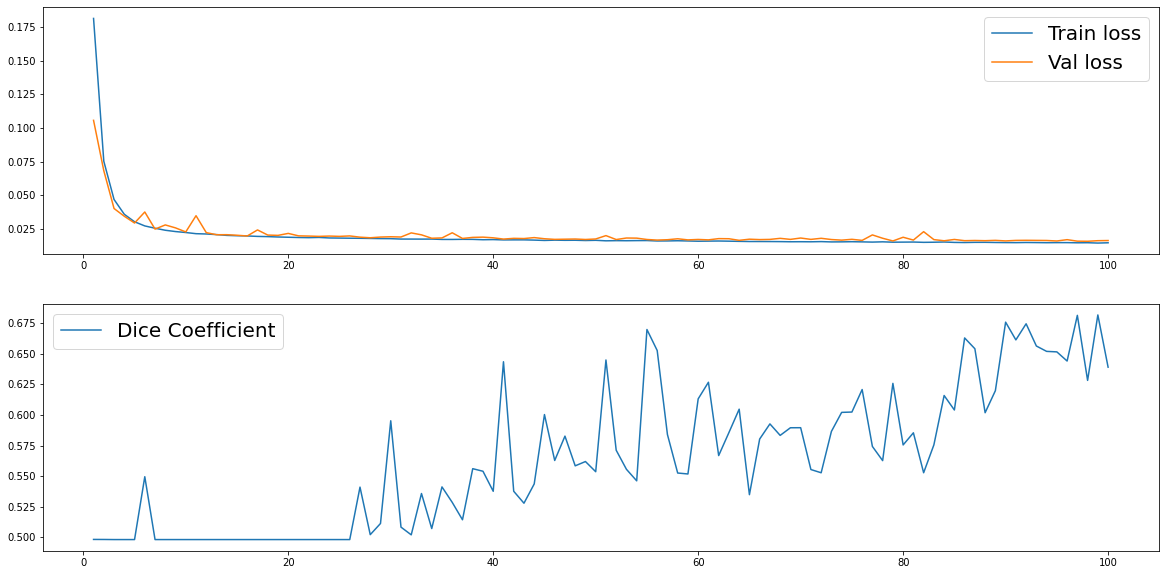

In [17]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize = (20, 10))
ax[0].plot(range(1, num_epochs + 1), train_loss_history, label = "Train loss")
ax[0].plot(range(1, num_epochs + 1), val_loss_history, label = "Val loss")
ax[1].plot(range(1, num_epochs + 1), dice_coeff_history, label = "Dice Coefficient" )
ax[0].legend(fontsize = 20)
ax[1].legend(fontsize = 20)
plt.savefig('UNet_prtrndevlmtrics.png')
plt.show()

In [18]:
imgs, mask = next(iter(val_loader))

In [19]:
mask[0]

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.uint8)

  0%|          | 0/4 [00:00<?, ?it/s]

torch.Size([1, 320, 320]) torch.Size([320, 320])


 25%|██▌       | 1/4 [00:01<00:04,  1.36s/it]

torch.Size([1, 320, 320]) torch.Size([320, 320])


 50%|█████     | 2/4 [00:02<00:02,  1.26s/it]

torch.Size([1, 320, 320]) torch.Size([320, 320])


 75%|███████▌  | 3/4 [00:03<00:01,  1.26s/it]

torch.Size([1, 320, 320]) torch.Size([320, 320])


100%|██████████| 4/4 [00:05<00:00,  1.26s/it]


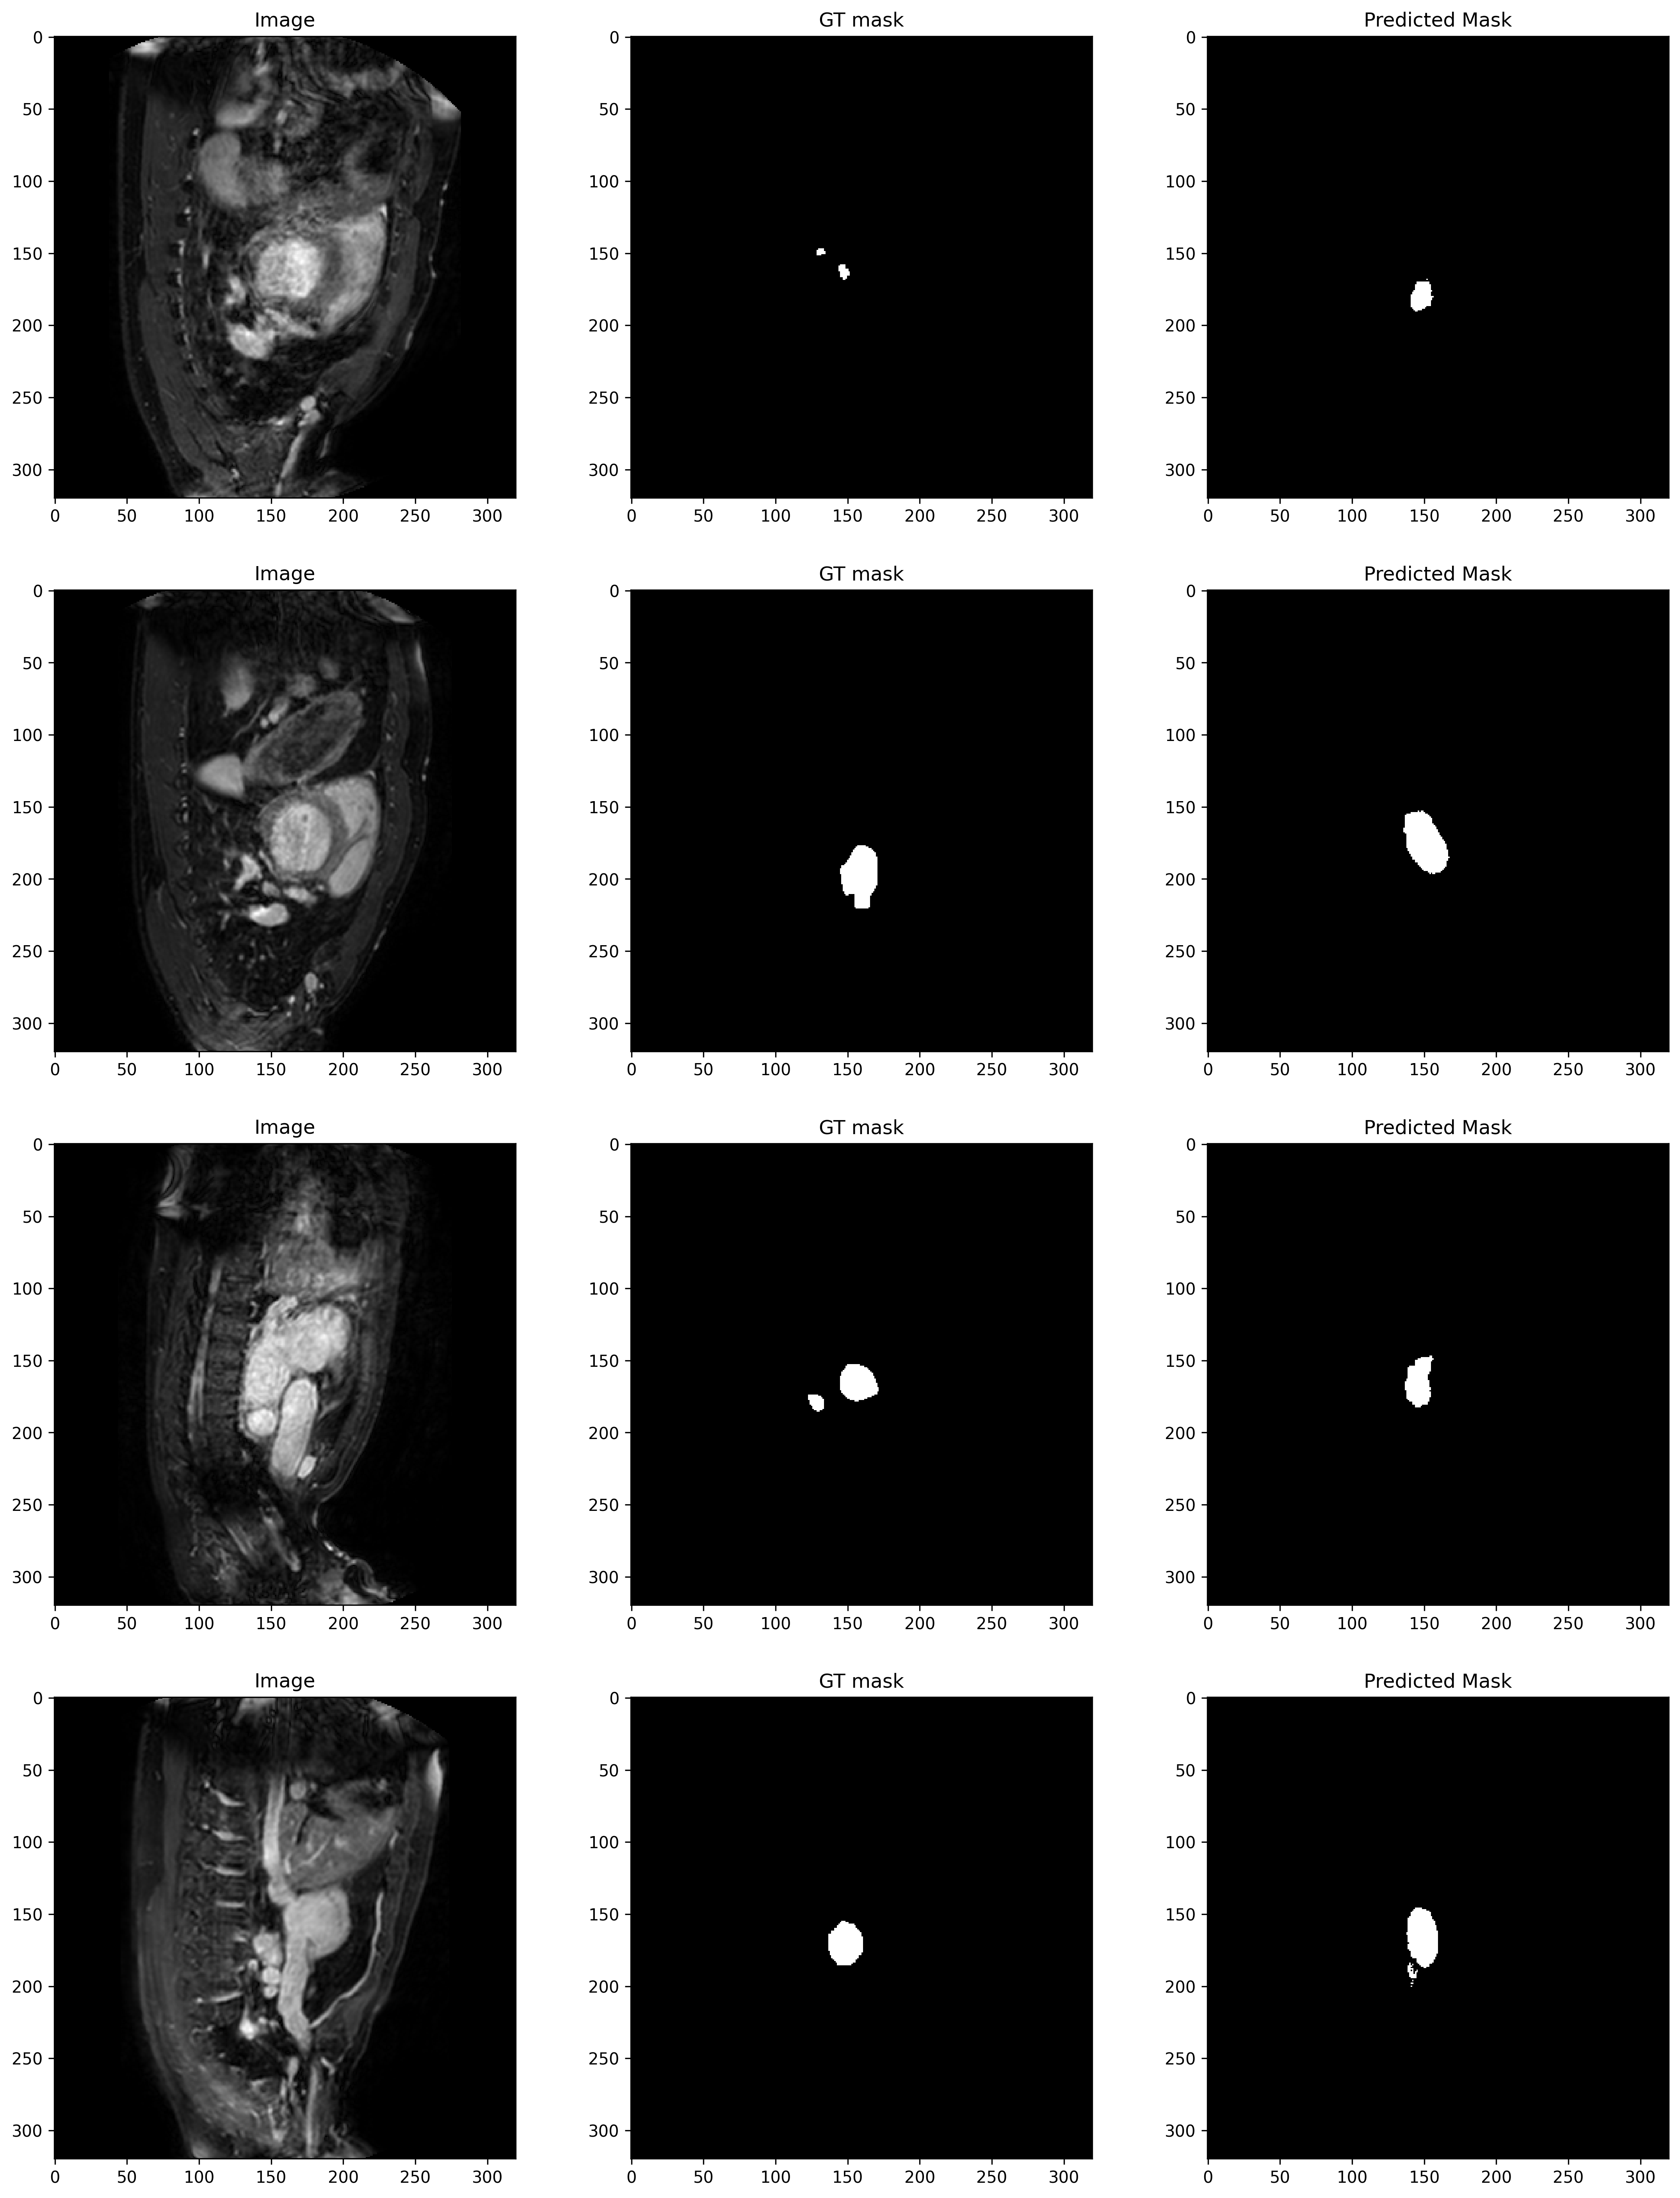

In [23]:
def show_few(loader = None, num = 5,):
    model = SUMNet_all_bn(in_ch = 1, out_ch = 2)
    model.load_state_dict(torch.load(os.path.join(checkpoint_dir, "best_weight.tar"),map_location = torch.device('cpu'))["model_state_dict"])
    model.to('cpu')
    model.eval()
    fig, ax = plt.subplots(nrows = num, ncols = 3, figsize = (18, num*6), dpi = 300)
    imgs, msk = next(iter(loader))
    for i in tqdm(range(num)):
        img = imgs[i]
        mask = msk[i]
        mask[mask == 1] == 255
        print(img.shape,mask.shape)
        with torch.no_grad():
            output = model(img.unsqueeze(0))
            _, pred_mask = output.max(1)
            pred_mask = pred_mask.squeeze(0).numpy()
            pred_mask[pred_mask == 1] = 255
        img = img.permute(1,2,0).numpy()
        ax[i,0].imshow(img,cmap='gray')
        ax[i,1].imshow(mask, cmap = 'gray')
        ax[i,2].imshow(pred_mask, cmap = 'gray')
        ax[i,0].set_title("Image")
        ax[i,1].set_title("GT mask")
        ax[i,2].set_title("Predicted Mask")
    plt.show()

show_few(val_loader , 4)